# Demostration

### This notebook generates a galaxy-galxy strong lensing system in DECaLS condidtion. It uses a real LRG from DECaLS. The source is sersic simply, and taken from Collect (2015).

In [4]:
import cv2
import os
import glob

import numpy as np
import pandas as pd
from astropy.io import fits

import matplotlib.pyplot as pl
import download_desi_img as ddi

import compose_class as compose_class
from scipy.ndimage import gaussian_filter
from astropy.cosmology import Planck18 as cosmo

#a random seed for each run
import time
t = 1000 * time.time() # current time in milliseconds
seed = int(t) % 2**32
np.random.seed(seed)

In [5]:
##functions

def Fluxr2Sigmav(zlens, re_arcsec, flux_r):
    
    #Use fundamental plane to estimate the velocity disp. of lens galaxy
    #Joseph B. Hyde and Mariangela Bernardi
    #https://doi.org/10.1111/j.1365-2966.2009.14783.x
    
    #np.random.seed(19960518)
    
    a_par = 1.4335; b_par = 0.3150; c_par = -8.8979

    Dd_angle = cosmo.angular_diameter_distance(zlens).value                     #Mpc

    re_rad = (re_arcsec/3600) * np.pi / 180
    re_kpc = re_rad * Dd_angle * 1000                                           #kpc

    flux_r_corrected = flux_r * 3.97 / 2
    m_r_corrected = 22.5 - 2.5 * np.log10(flux_r_corrected)
    m_r = 22.5 - 2.5 * np.log10(flux_r)

    miu_e = m_r + 5 * np.log10(re_arcsec) + 2.5 * np.log10(2 * np.pi) - 10 * np.log10(1+zlens)
    sigma = 10** ((1/a_par) * (np.log10(re_kpc) - b_par * miu_e - c_par)) * 1000 #SI
    sigma = sigma * np.random.normal(1, 0.1 , [1, 1])
    
    return sigma[0][0]/1000 #km/s

def MakeCertainFlux(ori,flux):
    return ori * (flux/ori.sum())

def XYTransform(x, y, x_cen, y_cen, phi):
    xnew = (x - x_cen) * np.cos(np.pi * phi / 180.0) + (y - y_cen) * np.sin(np.pi * phi / 180.0)
    ynew = -(x - x_cen) * np.sin(np.pi * phi / 180.0) + (y - y_cen) * np.cos(np.pi * phi / 180.0)
    return (xnew, ynew)

def GetDflAngle(x, y, lpar_local):
    
    # Calculating the img coordinate in source plane of an SIE mass profile following Kormann 1993
    # The convergence has the form of kappa(x, y)=0.5*sqrt(q)*b_sie/sqrt(x^2+q^2*y^2)
    # In this form, b_sie is the Einstein radius in the intermediate-axis convention
    # lpar[0]: lens einstein radius arcsec
    # lpar[1]: lens xcenter
    # lpar[2]: lens ycenter
    # lpar[3]: position angle in degreef
    # lpar[4]: axis ratio
    # lpar[3] = lpar[3]-90
    
    

    if lpar_local[4] > 1.0:
        lpar_local[4] = 1.0 / lpar_local[4]
        lpar_local[3] = lpar_local[3] + 90.0
    if lpar_local[3] > 180.0:
        lpar_local[3] = lpar_local[3] - 180.0
    elif lpar_local[3] < 0.0:
        lpar_local[3] = lpar_local[3] + 180.0
    (xnew, ynew) = XYTransform(x, y, lpar_local[1], lpar_local[2], lpar_local[3])  # rotational matrix
    
    

    r_sie = np.sqrt(xnew ** 2. + ynew ** 2.)
    qfact = np.sqrt((1.0 / lpar_local[4] - lpar_local[4]))
    eps = 10. ** (-8)
    
    if np.abs(qfact) <= eps:  # sie -> sis
        alpha_x = xnew / (r_sie + (r_sie == 0))
        alpha_y = ynew / (r_sie + (r_sie == 0))
    else:
        alpha_x = np.arcsinh(np.sqrt(1.0 / lpar_local[4] ** 2.0 - 1.0) * xnew / (r_sie + (r_sie == 0))) / qfact
        alpha_y =  np.arcsin(np.sqrt(1.0 - lpar_local[4] ** 2.0) * ynew / (r_sie + (r_sie == 0))) / qfact
        
    (alpha_x_new, alpha_y_new) = XYTransform(alpha_x, alpha_y, 0.0, 0.0, -lpar_local[3])
    return  (lpar_local[0]*alpha_x_new, lpar_local[0]*alpha_y_new)

def Sersic(xx,yy,Ie,re,n):
    
    theta = np.sqrt(xx**2+yy**2)
    
    bn = 1.9992*n-0.3271
    res = Ie*np.exp(-bn*((theta/re)**(1/n)-1))
    
    return res

def ApplyMaxValue(ori,max_value):
    scaling_factor = ori.max()/max_value
    return ori*(1/scaling_factor)

def Mag2Flux(mag):
    return 10**((1/2.5)*(22.5-mag))

def GetLensedSRCLight(magg_src,magr_src,magz_src,re_src,beta_xx,beta_yy):
    
    light = Sersic(ptch_sky_xx,ptch_sky_yy,1,re_src,n_src)
    light_g = MakeCertainFlux(light,Mag2Flux(magg_src))
    light_r = MakeCertainFlux(light,Mag2Flux(magr_src))
    light_z = MakeCertainFlux(light,Mag2Flux(magz_src))
    
    max_value_g = light_g.max()
    max_value_r = light_r.max()
    max_value_z = light_z.max()
    
    lnsd_g = ApplyMaxValue(Sersic(beta_xx,beta_yy,1,re_src,n_src),max_value_g)
    lnsd_r = ApplyMaxValue(Sersic(beta_xx,beta_yy,1,re_src,n_src),max_value_r)
    lnsd_z = ApplyMaxValue(Sersic(beta_xx,beta_yy,1,re_src,n_src),max_value_z)
    
    magnification = lnsd_g.sum()/light_g.sum()
    
    return lnsd_g,lnsd_r,lnsd_z,magnification

def ColorIMG(light_g,light_r,light_z):
    
    # function to create a composite png image
    
    max_g = light_g.max()
    max_r = light_r.max()
    max_z = light_z.max()
    img_rscl = max([max_g, max_r, max_z])
    img_thds = 1e-6
    img_g_rscl = light_g/img_rscl
    img_r_rscl = light_r/img_rscl
    img_z_rscl = light_z/img_rscl
    img_g_rscl[np.where(img_g_rscl<=img_thds)] = img_thds
    img_r_rscl[np.where(img_r_rscl<=img_thds)] = img_thds
    img_z_rscl[np.where(img_z_rscl<=img_thds)] = img_thds

    scales, offset, Q, alpha, masklevel, saturation, itype = (0.7,1.05,2.5), 0.0, 100, 0.2, -1.0, 'color', 'sum'
    object_RGB = compose_class.channel_RGB(RED=img_z_rscl, GREEN=img_r_rscl, BLUE=img_g_rscl)
    object_RGB.apply_scale(scales=scales)      
    object_RGB.lupton_stretch(Q=Q, alpha=alpha, itype=itype)
    object_RGB.pjm_mask(masklevel=masklevel)     
    object_RGB.pjm_offset(offset=offset)       
    object_RGB.lupton_saturate(saturation=saturation)
    object_RGB.pack_up()
    
    return object_RGB



def AddPOI(ideal_image=None,exposure=200):
    #add Poisson noise to lensed arcs
    
    image_with_noise = np.copy(ideal_image)
    image_= image_with_noise 
    counts = image_ * exposure  #ideal mean counts
    counts = np.random.poisson(counts, image_.shape) #possion counts base on ideal counts
    image_with_noise = counts*1.0/exposure #subtract the skylevel in image. this work can be done in pre-processing step
    poisson_noise = np.sqrt(counts)
    poisson_noise /= exposure  #-> counts/s
    return image_with_noise, poisson_noise

def CaculateEinsteinRadius(sigma_v,zd,zs):
    
    c=2.996e5 #km/s
    
    Ds_angle  = cosmo.angular_diameter_distance(zs).value         #Mpc
    Dds_angle = cosmo.angular_diameter_distance_z1z2(zd,zs).value #Mpc

    theta_e = 4 * np.pi * (sigma_v/c)**2 * (Dds_angle/Ds_angle) * (180/np.pi) * 3600
    
    return (theta_e)
    

In [6]:
# load in lens catalog

cmass_df = pd.read_csv("./cmass_bright.csv")
# cmass_df = pd.read_csv("./cmass.csv")
pxl_size_real = 0.27

# load in source catalog
# from: https://github.com/tcollett/LensPop (lense_DESa,b,c merged)
# source_magi_df = pd.read_csv("./source_magi.csv")
source_df = pd.read_csv("./catalogue_t.csv")

# 1. Lens

## 1.1 Select a Lens Galaxy

In [7]:
import matplotlib.pyplot as plt

In [8]:
## choose a lens from catalog
cmass_idx = 5

In [9]:
#print info
cmass_df.iloc[cmass_idx]

Unnamed: 0           1203
Unnamed: 0.1         1203
ra_1             0.370623
dec_1             31.2354
TYPE                  DEV
g                 19.9803
r                 19.3023
z                 18.5905
w1                17.9549
w2                17.9339
rg_EXP                  0
rg_DEV            8.92236
fluxg             10.1829
fluxr             19.0149
fluxz             36.6275
fluxw1            65.7721
fluxw2            67.0593
shapeexp_e1             0
shapeexp_e2             0
shapedev_e1     0.0286391
shapedev_e2      0.398936
col1               755501
ra_2              0.37072
dec_2             31.2354
redshift          0.59297
weight                  1
mass_stellar      11.3008
Separation       0.320033
Name: 5, dtype: object

In [10]:
# record info
ra  = cmass_df.iloc[cmass_idx]["ra_1"]
dec = cmass_df.iloc[cmass_idx]["dec_1"]
zd  = cmass_df.iloc[cmass_idx]["redshift"]
lens_name_png  = "ra_"+str(ra)+"_dec_"+str(dec)+".png"
lens_name_fits = "ra_"+str(ra)+"_dec_"+str(dec)+".fits"

## 1.2 Observational Stamp of Lens

In [11]:
# download fits and png of the selected lens from Decals Data base

if not os.path.isfile("./stamp/png/"+lens_name_png):
    ddi.DownloadByRaDec_PNG(ra,dec)
if not os.path.isfile("./stamp/fits/"+lens_name_fits):
    ddi.DownloadByRaDec_FITS(ra,dec)

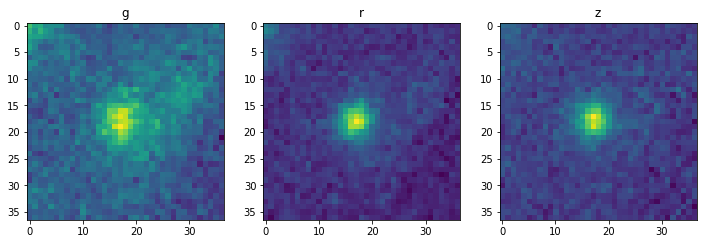

In [12]:
# read out image of the lens
# g, r, and z band images
lens_fits = fits.open("./stamp/fits/"+lens_name_fits)
lens_img = lens_fits[0].data
lens_img_g = lens_img[0]
lens_img_r = lens_img[1]
lens_img_z = lens_img[2]

_, axs = plt.subplots(1, 3, figsize=(12, 12))
axs[0].imshow(lens_img_g)
axs[0].set_title('g')
axs[1].imshow(lens_img_r)
axs[1].set_title('r')
axs[2].imshow(lens_img_z)
_ = axs[2].set_title('z')

## 1.3 Read Lens Catalog

In [13]:
# read the ellpticity, P.A., re, flux and redshift
e1_lens = cmass_df.iloc[cmass_idx]["shapedev_e1"]
e2_lens = cmass_df.iloc[cmass_idx]["shapedev_e2"]
re_lens = cmass_df.iloc[cmass_idx]["rg_DEV"] * pxl_size_real  #is the unit of rg_DEV pixel? need check
fluxg_lens = cmass_df.iloc[cmass_idx]["fluxg"]
fluxr_lens = cmass_df.iloc[cmass_idx]["fluxr"]
fluxz_lens = cmass_df.iloc[cmass_idx]["fluxz"]
e_lens  = np.sqrt(e1_lens**2+e2_lens**2)
pa_lens = np.rad2deg(0.5*np.arctan2(e2_lens,e1_lens)) #clockwise direction is postive, +Y is zero
q_lens  = 1-e_lens

lens_img_g = MakeCertainFlux(lens_img_g,fluxg_lens)
lens_img_r = MakeCertainFlux(lens_img_r,fluxr_lens)
lens_img_z = MakeCertainFlux(lens_img_z,fluxz_lens)

## 1.4 Mass Model

In [14]:
sgmv = Fluxr2Sigmav(zd,re_lens,fluxr_lens)
print(sgmv,pa_lens,q_lens,re_lens,e_lens)

254.44457981715124 42.94692583233678 0.6000371372837805 2.4090382800000003 0.39996286271621945


# 2. Source

## 2.1 Select a Source Galaxy, Read Source Catalog

In [15]:
#select lens from our catalog
lens_name = 'gal00010'

In [33]:
## get test source galaxy
# image
fname = glob.glob('allgals_flattened/JWST{}*.fits'.format(lens_name))[0]
lens_test_fits = fits.open(fname)
lens_img_g = lens_img_r = lens_img_z = lens_test_fits[0].data
# catalogue
s_z, s_pixscale, s_obs2phys, s_semimaj, s_axisrat, s_mag160, s_ra, s_dec = \
list(source_df[source_df['galaxy'] == lens_name].values[0][1:])
# print source info
source_df[source_df['galaxy'] == lens_name]


# s_pixscale: pc/pix
# s_obs2phys: kpc per arcsec

,galaxy,redshift,pixscale,obs2phys,semimaj,axisrat,mag160,ra,dec
6,gal00010,2.755,20.0,7.888097,0.2,0.45,25.5403,34.497007,-5.219383


In [19]:
# pixel scale (arcsec per pixel)
pxl_size_source = s_pixscale / 1000 / s_obs2phys

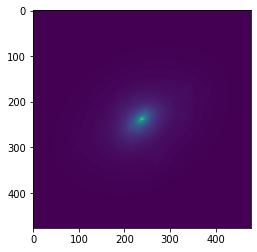

In [20]:
## check test source galaxy
# plot (same data for g,r,z)
pl.imshow(lens_img_z)

In [34]:
#source info
lens_test_fits_orig = fits.open("./allgals_forstacking/"+ fname.split('/')[-1].replace('_flat', ''))
source_header = lens_test_fits_orig[0].header

zs = source_header['REDSHIFT']
n_src = source_header['SERSIC']

re_src = magg_src = magr_src = magz_src = source_header['SEMIMAJ'] ##

#show info on the source
source_header[0:23]

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  477                                                  
NAXIS2  =                  477                                                  
EXTEND  =                    T                                                  
ROW     =                   10 / Row in final_data_set3.fits                    
REDSHIFT=                2.755                                                  
MAG160  =              25.5403                                                  
MAG606  =              26.0432                                                  
OBS2PHYS=    7.888097168553559 / kpc per arcsec                                 
RA      =           34.4970067 / Right Ascension                                
DEC     =           -5.21938

# 3. Lensed Images

## 3.1 Generate Ideal Lensed Image

In [35]:
## source positions
#source_x, source_y = np.random.randint(-10, 10)/10, np.random.randint(-10, 10)/10 #arcsec,arcsec
source_x, source_y = 0, 0 #arcsec,arcsec
print("Source position: ", source_x, ", ", source_y)

Source position:  0 ,  0


In [51]:
# Einstein Radius
theta_e      = CaculateEinsteinRadius(sgmv,zd,zs)

# Lens Parameters to define a SIE profile
lpar = np.array([theta_e,source_x,source_y,pa_lens,q_lens]) 


# generate ideal lensed arcs with ray-tracing method 
# lensing happens at here
# all in arcsec

scl = 3
xmin = -scl
xmax =  scl
ymin = -scl
ymax =  scl

pxl_size = pxl_size_source

ptch_sky_xx, ptch_sky_yy = np.mgrid[xmin:xmax+pxl_size:pxl_size, ymin:ymax+pxl_size:pxl_size]
ptch_sky_xx[ptch_sky_xx==0] = 1e-8
ptch_sky_yy[ptch_sky_yy==0] = 1e-8
alpha_xx, alpha_yy = GetDflAngle(ptch_sky_xx, ptch_sky_yy, lpar)

beta_xx   = ptch_sky_xx  - alpha_xx
beta_yy   = ptch_sky_yy  - alpha_yy

light_src_g,light_src_r,light_src_z,magnification = \
GetLensedSRCLight(magg_src,magr_src,magz_src,re_src,beta_xx,beta_yy)

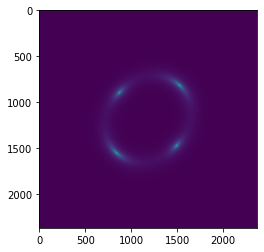

In [52]:
# pl.imshow(light_src_g)
# pl.savefig("./mock/s{}_light_src.png".format(n_source))
pl.imshow(np.flipud(light_src_g))
#pl.savefig("./mock/s{}_light_src.png".format(n_source))

## 3.2 PSF & Noise

In [53]:
#add psf

#PSF scale
g_psf_fwhm_decals = 1.26662
r_psf_fwhm_decals = 1.13551
z_psf_fwhm_decals = 1.11053

light_src_g_psf = gaussian_filter(light_src_g, sigma=g_psf_fwhm_decals/pxl_size/2.355)
light_src_r_psf = gaussian_filter(light_src_r, sigma=g_psf_fwhm_decals/pxl_size/2.355)
light_src_z_psf = gaussian_filter(light_src_z, sigma=g_psf_fwhm_decals/pxl_size/2.355)

In [54]:
#rebin the image to match the pixel size of DeCaLs images
light_src_g_psf_low = cv2.resize(light_src_g_psf,lens_img_g.shape,interpolation=cv2.INTER_CUBIC)
light_src_r_psf_low = cv2.resize(light_src_r_psf,lens_img_r.shape,interpolation=cv2.INTER_CUBIC)
light_src_z_psf_low = cv2.resize(light_src_z_psf,lens_img_z.shape,interpolation=cv2.INTER_CUBIC)

light_src_g_psf_low[light_src_g_psf_low<0] = 1e-20
light_src_r_psf_low[light_src_r_psf_low<0] = 1e-20
light_src_z_psf_low[light_src_z_psf_low<0] = 1e-20

light_src_g_psf_low = MakeCertainFlux(light_src_g_psf_low,light_src_g.sum())
light_src_r_psf_low = MakeCertainFlux(light_src_r_psf_low,light_src_r.sum())
light_src_z_psf_low = MakeCertainFlux(light_src_z_psf_low,light_src_z.sum())

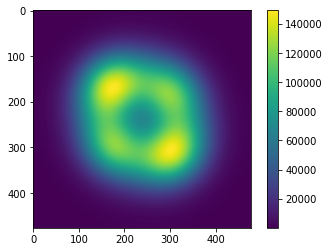

In [55]:
pl.imshow(light_src_g_psf_low)
pl.colorbar()

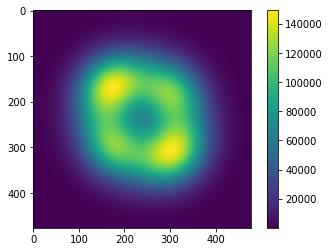

In [56]:
light_src_g_psf_low_poi,t = AddPOI(ideal_image=light_src_g_psf_low, exposure=166)
light_src_r_psf_low_poi,_ = AddPOI(ideal_image=light_src_r_psf_low, exposure=134)
light_src_z_psf_low_poi,_ = AddPOI(ideal_image=light_src_z_psf_low, exposure=200)
pl.imshow(light_src_z_psf_low_poi)
pl.colorbar()

In [57]:
22.5-2.5*np.log10(light_src_g_psf_low.sum()),22.5-2.5*np.log10(light_src_g_psf_low_poi.sum())

(-2.25639673175257, -2.2563963129060305)

In [58]:
light_src_g_psf_low.sum(),light_src_g_psf_low_poi.sum()

(7990219181.389527, 7990216098.98795)

# 4. Mock g-g SL system

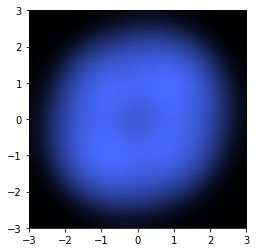

In [59]:
pl.imshow(ColorIMG(light_src_g_psf_low_poi,light_src_r_psf_low_poi,light_src_z_psf_low_poi).imgRGB, extent=[-scl,scl,-scl,scl])

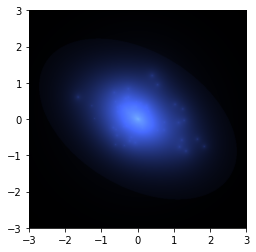

In [60]:
#lens img
pl.imshow(ColorIMG(lens_img_g,lens_img_r,lens_img_z).imgRGB, extent=[-scl, scl,-scl,scl])

Text(0, 0.5, '$arcsec$')

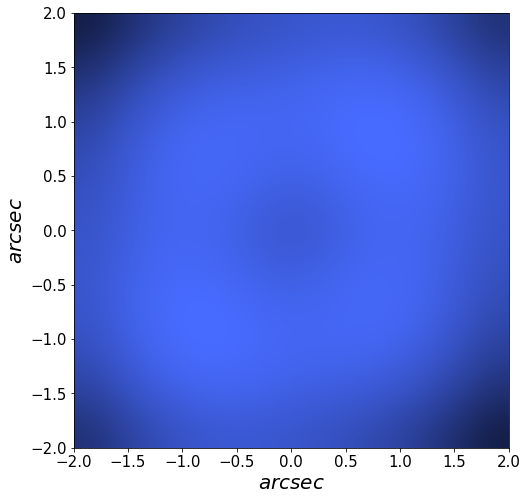

In [47]:
## Paste lensed arcs to the lens image

mock_g = light_src_g_psf_low_poi + lens_img_g
mock_r = light_src_r_psf_low_poi + lens_img_r
mock_z = light_src_z_psf_low_poi + lens_img_z

# create a composite png image to demonstrate the final output
mock_color = ColorIMG(mock_g,mock_r,mock_z)

# visualization
pl.figure(figsize=(8,8))
pl.imshow(mock_color.imgRGB, extent=[-scl,scl,-scl,scl])
t=pl.xticks(fontsize=15)
t=pl.yticks(fontsize=15)
pl.xlabel("$arcsec$",fontsize=20)
pl.ylabel("$arcsec$",fontsize=20)

In [48]:
#save as fits
def save_simulated_img(ra, dec, mock_g, mock_r, mock_z, fname):
    #save scale info (everything to reproduce images?)
    data = np.zeros((40000, 40000), dtype=np.float64)
    hdu = fits.PrimaryHDU(data=np.stack((mock_g, mock_r, mock_z)))
    header = hdu.header
    header['RA'] = ra
    header['Dec'] = dec
    hdu.writeto(fname)

In [49]:
save_simulated_img(ra, dec, mock_g, mock_r, mock_z, 'test__.fits')

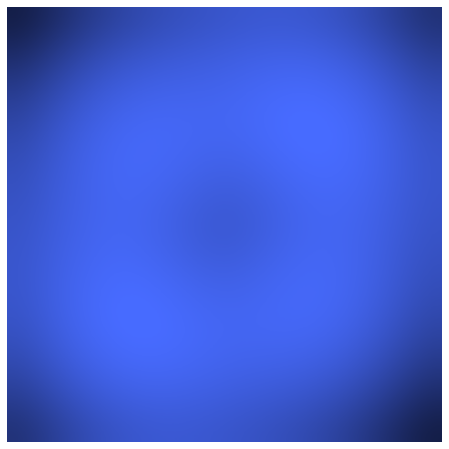

In [61]:
#save
pl.figure(figsize=(8,8))
pl.axis("off")
pl.imshow(mock_color.imgRGB)

if not os.path.exists("./mock"):
    os.system("mkdir ./mock")
    
pl.savefig("./mock/s{}_demo.png".format('test'))

In [437]:
# save the parameters of this mock lens

with open('./mock/s{}_parameters.txt'.format(n_source), 'w') as f:
    f.write("Lens index: " + str(cmass_idx) + '\n')
    f.write("Source index: " + str(source_idx) + '\n')
    f.write('---------------------------------'+ '\n')
    f.write("sgmv of lens: " + str(round(sgmv,2)) + " km/s" + '\n')
    f.write("magnification: " + str(round(magnification,2)) + '\n')
    f.write("zd, zs, Einstein radius(arcsec): " + str(round(zd,2)) + str(round(zs,2)) + str(round(theta_e,2)) + '\n')
    f.write("magi of lens   (g,r,z): " + str(round(cmass_df.iloc[cmass_idx]["g"],2)) +
            str(round(cmass_df.iloc[cmass_idx]["r"],2)) + str(round(cmass_df.iloc[cmass_idx]["z"],2)) + '\n')
    f.write("magi of source (g,r,z): " + str(magg_src) + str(magr_src) + str(magz_src) + '\n')
    f.write("lensed source fluxr / lens fluxr:" + str(round(light_src_r.sum()/lens_img_r.sum(),2)))

In [438]:
# # list the parameters of this mock lens

# print("sgmv of lens:", round(sgmv,2),"km/s")
# print("magnification:",round(magnification,2))
# print("zd,zs,Einstein radius(arcsec):", round(zd,2),round(zs,2),round(theta_e,2),)
# print("magi of lens   (g,r,z):",\
#       round(cmass_df.iloc[cmass_idx]["g"],2),round(cmass_df.iloc[cmass_idx]["r"],2),round(cmass_df.iloc[cmass_idx]["z"],2))
# print("magi of source (g,r,z):",magg_src,magr_src,magz_src)
# print("lensed source fluxr / lens fluxr:",round(light_src_r.sum()/lens_img_r.sum(),2))